# Setup Code

In [65]:
# some setup code
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import itertools

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import layers
import solvers
import nets

from params import *
from config import *

import utils

%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

utils.print_info()

params = MNISTParameters()
img_size = params.img_size
img_channel = params.img_channel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.4.0
using device: cuda
data type: torch.float32
VERBOSE== False


# Data Loading

In [44]:
dataloader = utils.dataLoader('MNIST')

# Network Architecture

In [3]:
#test S encoder
nets.test_Encoder(nets.S_Encoder(params),params)
#test z encoder
nets.test_Encoder(nets.Z_Encoder(params),params)
#test s classifier
nets.test_classifier(nets.S_Classifier(params),params)
#test decoder
nets.test_Decoder(nets.SZ_Decoder(params),params)

torch.Size([64, 16])

torch.Size([64, 16])

torch.Size([64, 10])

torch.Size([64, 1, 28, 28])



# Step1: train s encoder and classifier
the encoder+classifier structure has achieved 97% accuracy on MNIST

In [45]:
s_enc = nets.S_Encoder(params)
s_classifier = nets.S_Classifier(params)
classifier_solver = solvers.ClassifierSolver(s_enc, s_classifier, dataloader, params)


In [47]:

#new_s_enc = nets.S_Encoder(params)
utils.save_models(s_enc,mode='param',mode_param = '')
utils.load_models(s_enc,path=var_save_path,suffix='')

In [46]:
classifier_solver.train(20)
classifier_solver.test(mode = 'test')

iteration 1000, loss = 0.2386
Checking accuracy on validation set
Got 4885 / 5000 correct (97.70)

iteration 2000, loss = 0.0652
Checking accuracy on validation set
Got 4905 / 5000 correct (98.10)

iteration 3000, loss = 0.0373
Checking accuracy on validation set
Got 4908 / 5000 correct (98.16)

Checking accuracy on test set
Got 4899 / 5000 correct (97.98)


0.9798

## test decoder
you can skip this sub session
you can use test_recon in solvers.py to check recon results

In [37]:
def full_test_Decoder(model,optimizer,epochs = 2):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    print_every = 500
    for e in range(epochs):
        for t, (x, _) in enumerate(loader_train):
            model.train()  # put model to training mode
            y = x.clone()
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            reconstruction = model(x)
            loss = nn.MSELoss(size_average=False)(reconstruction, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print()
szdec = SZ_Decoder()
layers.set_trainable(s_enc,True)
layers.set_trainable(s_enc,True)

modelDecTest = layers.DecoderTest(s_enc, szdec)
optimizerDecTest = solvers.get_optimizer(modelDecTest)
layers.set_trainable(s_enc,True)
layers.set_trainable(szdec,True)

full_test_Decoder(modelDecTest,optimizerDecTest,20)

NameError: name 'SZ_Decoder' is not defined

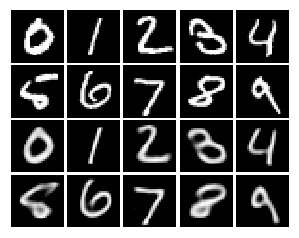

In [160]:
solvers.test_recon( modelDecTest, dataloader)

## some images in the test set

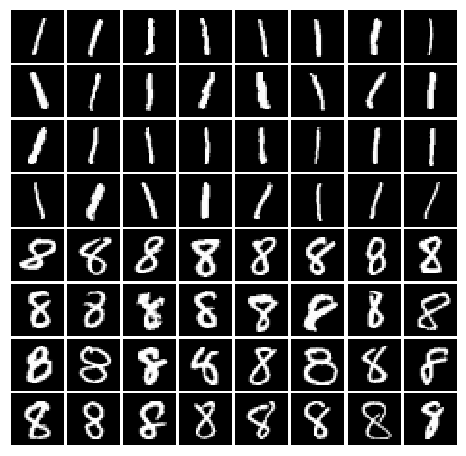

In [92]:
img_stat = [[] for i in range(params.classes_num)]
for it, (xbat,ybat) in enumerate(dataloader.loader_test):
    for i in range(len(ybat)):
        x = xbat[i]
        y = ybat[i]
        img_stat[y.item()].append( x.view(img_size*img_size) )
#print([img_stat[0][i].view(784) for i in range(20)])
showed = [img_stat[1][i] for i in range(32)]
showed += [img_stat[8][i] for i in range(32)]
torch.stack(showed)
utils.show_images(torch.stack(showed))

# Step two, train disentangle-adversariel network

In [11]:
def get_DisAdvSolver(loading=False,name = ''):
    if loading==False:
        z_enc = nets.Z_Encoder(params)
        z_adv = nets.Z_AdvLayer(params)
        sz_dec= nets.SZ_Decoder(params)
        s_encoder = s_enc
        solver = solvers.DisAdvSolver(s_encoder, z_enc, sz_dec, z_adv, dataloader, params)
    else:
        solver = solvers.DisAdvSolver(dloader=dataloader,params=params, loading=True,loadSuffix=name,model_name='trueTest',saving_while_training=True)
    return solver

In [12]:
solver = get_DisAdvSolver(loading=True,name='(0.001, (0.9, 0.999), -2, 4)')

In [70]:
utils.load_models(s_enc,path=var_save_path,suffix='')
solver = get_DisAdvSolver(loading=False)

Checking accuracy on test setrecon:0.0877, disent:0.0877, adv:1.7971  adv:1.9601 
Got 340 / 5000 correct (6.80)
training a classifier on top of z encoder...
testing this classifier...
Checking accuracy on test set
Got 1950 / 5000 correct (39.00)
z_latent_norm: tensor(9.2204, device='cuda:0')


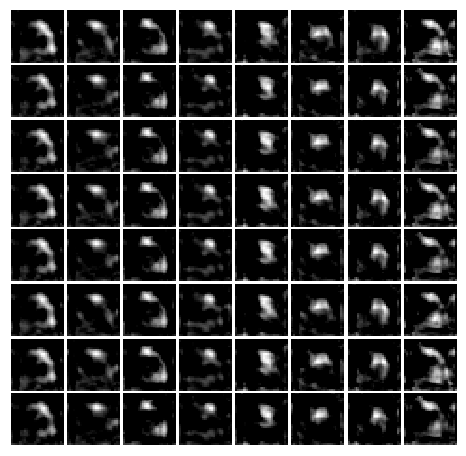

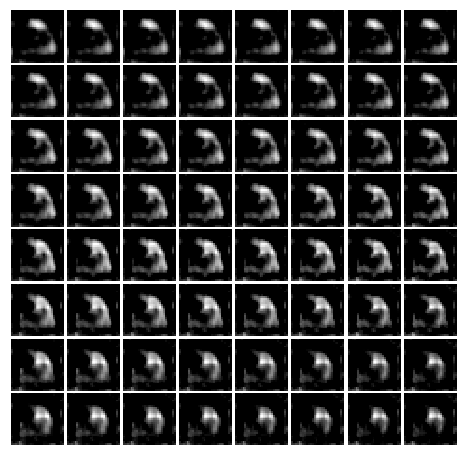

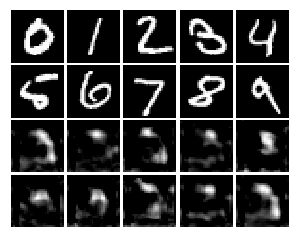

In [71]:
solver.train(10)

reconstruction loss curve


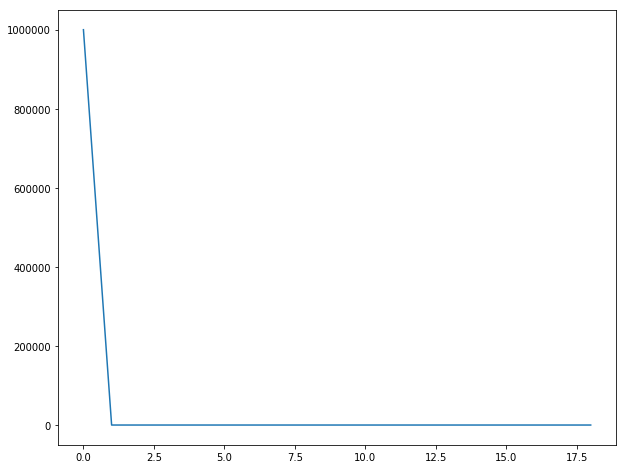

In [68]:
solver.plot_history()

In [208]:
hyper_tuner = solvers.HPTuner(s_enc,dataloader,params)

learning_rate, hlayer_size, training_epochs_num, reg_strengths
training in this scheme: 1/1
(0.001, (0.9, 0.999), -2, 4)

progress: 1.00, lastes loss, recon:0.0535, disent:-0.1889, adv:2.0422, adv_acc:0.2152 
Iter: 24000, rencon_loss: 0.05351, disent_loss:-0.1889, adv_loss: 2.042
adv classifier accuracy:
Checking accuracy on test set
Got 497 / 5000 correct (9.94)
training a classifier on top of z encoder...
testing this classifier...
Checking accuracy on test set
Got 1397 / 5000 correct (27.94)
z_latent_norm: tensor(332.4793, device='cuda:0')


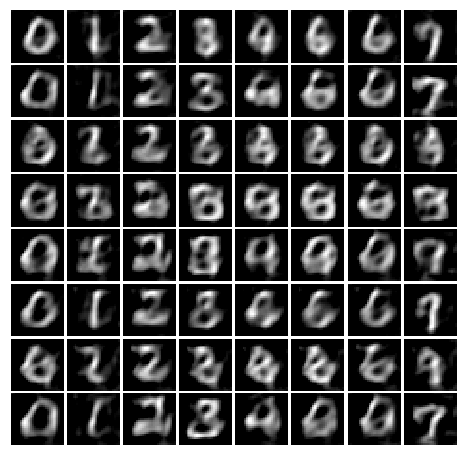

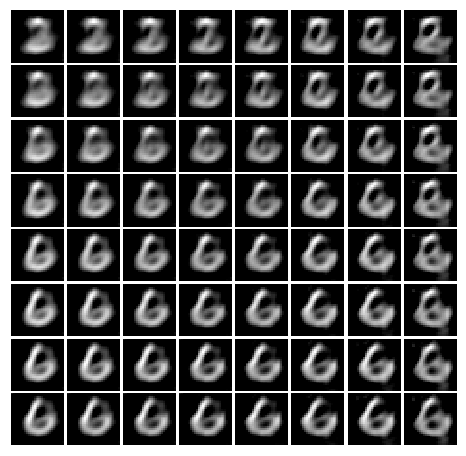

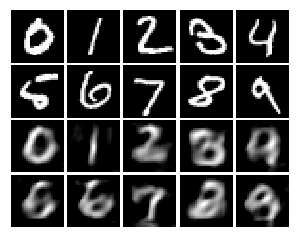

reconstruction loss curvess, recon:0.0640, disent:-357.8739, adv:3836.3149, adv_acc:0.0920 


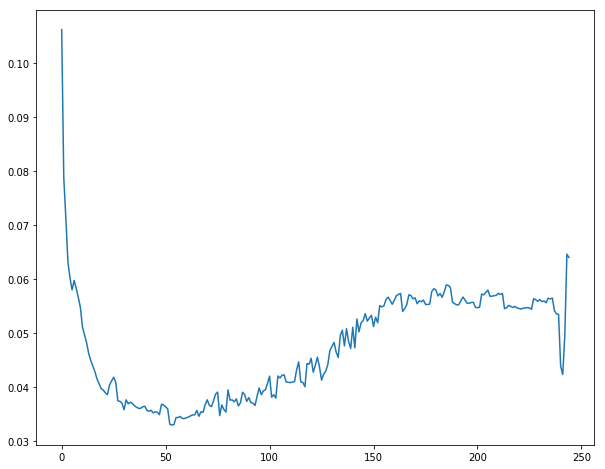

saving model...


In [212]:
hyper_tuner.tune(500)

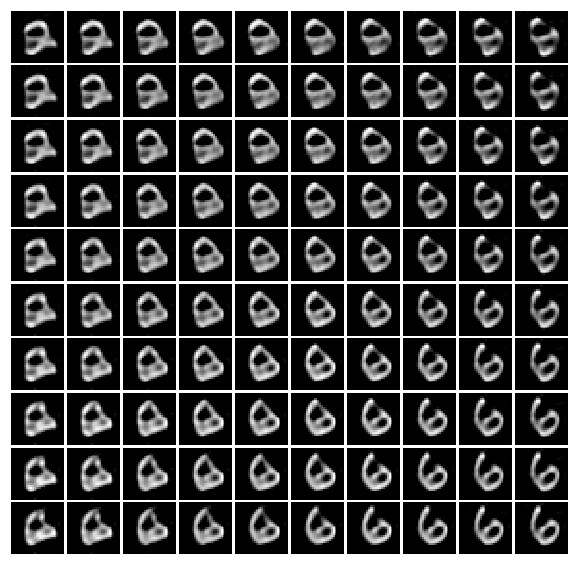

In [41]:
solver.show_interpolated(10)

In [121]:
from copy import deepcopy
z_enc_back2 = deepcopy(z_enc)
z_adv_back2 = deepcopy(z_adv)
sz_dec_back2= deepcopy(sz_dec)
s_enc_back2 = deepcopy(s_enc)
back_save_lists = [z_enc_back,z_adv_back,sz_dec_back,s_enc_back]
utils.save_models(back_save_lists,path=save_path)

PicklingError: Can't pickle <class 'layers.ConvLayer'>: it's not the same object as layers.ConvLayer

z_latent_norm: tensor(765.8068, device='cuda:0')


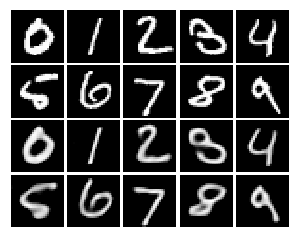

In [247]:
recon_net = layers.ReconNet(s_enc,z_enc,sz_dec)
solvers.test_recon(recon_net,dataloader)

In [97]:
def show_results(dis_adv_solver):
    dis_adv_solver.show_switch_latent()
    
    show_pairs = [((2,18),(6,10)),((1,25),(8,30)),((0,0),(1,0))]
    for pairs in show_pairs:
        dis_adv_solver.show_interpolated(10,tuples=pairs)

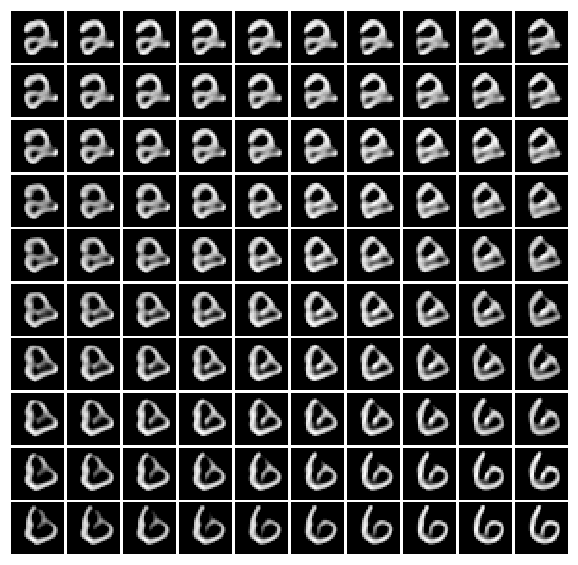

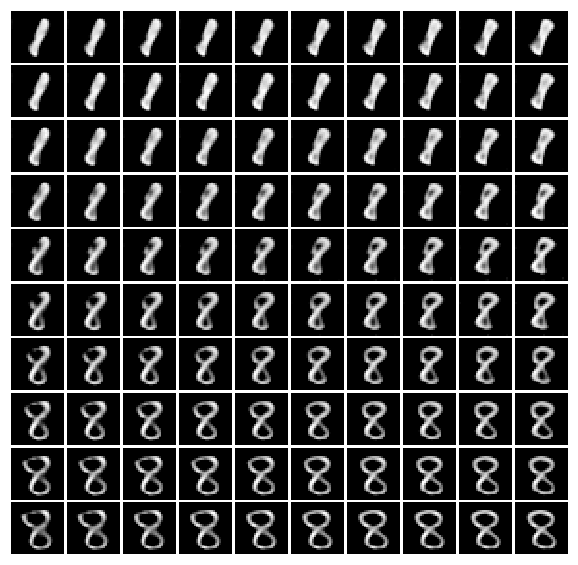

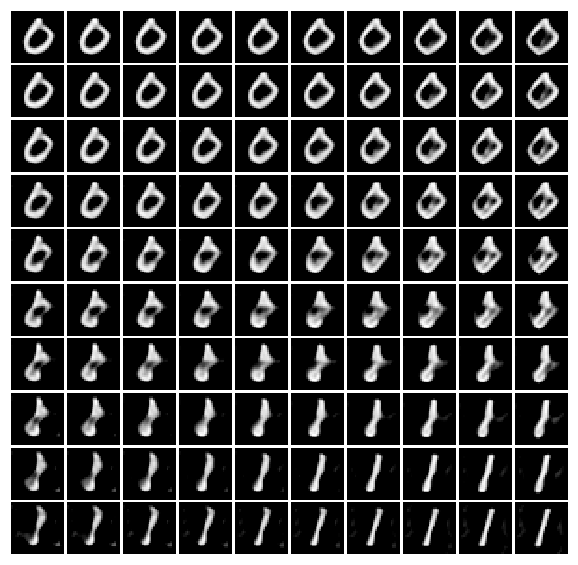

In [248]:
show_results(dis_adv_solver)

In [182]:
back_save_lists = [z_enc_back,z_adv_back,sz_dec_back,s_enc_back]
utils.save_models(back_save_lists,path=save_path)

NameError: name 'z_enc_back' is not defined

In [107]:
def show_switch_latent(self):
    s_latent=[]
    z_latent=[]
    img_lists = []
    s_enc = self.s_enc
    z_enc = self.z_enc
    sz_dec = self.sz_dec

    for classi in range(params.classes_num):
        img = self.dloader.img_grouped[classi][2].view(1,img_channel,img_size,img_size)
        img = img.to(device=device,dtype=dtype)
        
        s_latent.append( s_enc(img) )
        z_latent.append( z_enc(img) )
    for row in range(params.classes_num):
        for col in range(params.classes_num):
            latent = torch.cat((s_latent[col],z_latent[row]),dim=1)
            recon  = sz_dec(latent)
            img_lists.append(recon.view( img_size*img_size ) )

    utils.show_images(torch.stack(img_lists).detach().cpu().numpy())
dis_adv_solver.show_switch_latent()

AttributeError: 'DisAdvSolver' object has no attribute 'show_switch_latent'